<a href="https://colab.research.google.com/github/minelli31/Competitive-Lotka-Volterra-equations/blob/main/Copia_de_Person_re_identification_with_triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Person re-identification using siamese network with triplet loss 

## Library imports

In [1]:
import tensorflow as tf
import keras
from keras import layers, losses, optimizers
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from keras.applications import vgg16
from keras import metrics
from keras import Model
import imageio.v2 as imageio
import numpy as np

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)



Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Sat Jun 10 15:10:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
    

## Download dataset

In [2]:
!gdown --id 1lZHRR6mwwGhQjbUrSu9VKVCjJFhN8e4u # train.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1lZHRR6mwwGhQjbUrSu9VKVCjJFhN8e4u
To: /content/train.rar
100% 2.43G/2.43G [00:43<00:00, 55.8MB/s]


In [3]:
!gdown 1c8FUnOBLotFFTgYEZ-56dHjB3r1CKEko #train_p
!gdown 1ZNmXLJONCmH6lzJOqcOLuDQGZMqs0Xj3 #train_n
!gdown 1RDQhlCG1LH_2fTGHxhBBSX5ku4yEUVwy #train_an

Downloading...
From: https://drive.google.com/uc?id=1c8FUnOBLotFFTgYEZ-56dHjB3r1CKEko
To: /content/train_p.txt
100% 14.5M/14.5M [00:00<00:00, 48.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZNmXLJONCmH6lzJOqcOLuDQGZMqs0Xj3
To: /content/train_n.txt
100% 14.5M/14.5M [00:00<00:00, 213MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RDQhlCG1LH_2fTGHxhBBSX5ku4yEUVwy
To: /content/train_an.txt
100% 14.5M/14.5M [00:00<00:00, 39.5MB/s]


In [4]:
!gdown 15MseZ3rXqSLQ7s5CIwOS6k55GQrF1gAZ # val_p
!gdown 1w8JpjbwFeRe7c08ejSGotY5U_k87IwuK # val_n
!gdown 1qNSqZ5iB2mIvTw9nOQU6bIugcB6YW9SI # val_an

Downloading...
From: https://drive.google.com/uc?id=15MseZ3rXqSLQ7s5CIwOS6k55GQrF1gAZ
To: /content/val_p.txt
100% 580k/580k [00:00<00:00, 19.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1w8JpjbwFeRe7c08ejSGotY5U_k87IwuK
To: /content/val_n.txt
100% 580k/580k [00:00<00:00, 156MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qNSqZ5iB2mIvTw9nOQU6bIugcB6YW9SI
To: /content/val_an.txt
100% 580k/580k [00:00<00:00, 189MB/s]


In [5]:
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!unrar x train.rar -idq

## Loading data

In [7]:
#input_shape = (128, 64, 3)
#train mean shape
  #input_shape = (245, 89, 3)
#train+test mean shape
input_shape = (205, 71, 3)

# The function preprocesses an image for use in a TensorFlow model 
# by reading, decoding, converting, and resizing the image.

def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, input_shape[:-1])
    
    return image

def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [8]:
def read_triplets(anchor_path, positive_path, negative_path):
    # Get valid image paths and labels for anchoe, positive an negative data
    anchor_images, anchor_labels = [], []
    positive_images, positive_labels = [], []
    negative_images, negative_labels = [], []
    # Get the mean shape
    dim_anchor1 = []
    dim_anchor2 = []
    dim_positive1 = []
    dim_positive2 = []
    dim_negative1 = []
    dim_negative2 = []
    dim1 = []
    dim2 = []
    with open(anchor_path) as anchor_file, \
         open(positive_path) as positive_file, \
         open(negative_path) as negative_file:
             for line1, line2, line3 in zip(anchor_file, positive_file, negative_file):
                line1, line2, line3 = line1.strip().split(), line2.strip().split(), line3.strip().split()
                anchor_image_path, anchor_label = line1
                positive_image_path, positive_label = line2
                negative_image_path, negative_label = line3
                if os.path.isfile(anchor_image_path) and \
                   os.path.isfile(positive_image_path) and \
                   os.path.isfile(negative_image_path): 

                    # Read the image to get its shape
                    anchor_image = imread(anchor_image_path)
                    positive_image = imread(positive_image_path)
                    negative_image = imread(negative_image_path)

                    d_anchor1,d_anchor2,colors_anchor = anchor_image.shape
                    dim_anchor1.append(d_anchor1)
                    dim_anchor2.append(d_anchor2)

                    d_positive1,d_positive2,colors_positive = positive_image.shape
                    dim_positive1.append(d_positive1)
                    dim_positive2.append(d_positive2)

                    d_negative1,d_negative2,colors_negative = negative_image.shape
                    dim_negative1.append(d_negative1)
                    dim_negative2.append(d_negative2)

                    dim1 = float(d_anchor1 + d_positive1 + d_negative1)/3
                    dim2 = float(d_anchor2 + d_positive2 + d_negative2)/3

                    anchor_images.append(anchor_image_path)
                    positive_images.append(positive_image_path)
                    negative_images.append(negative_image_path)
                    anchor_labels.append(int(anchor_label))
                    positive_labels.append(int(positive_label))
                    negative_labels.append(int(negative_label))
                      # Print the shape of the images
                    #print(f"Anchor image shape: {anchor_image.shape}")
                    #print(f"Positive image shape: {positive_image.shape}")
                    #print(f"Negative image shape: {negative_image.shape}")
                      # Print mean shape of the images               
    print(f"Anchor image shape: {np.mean(dim_anchor1):.0f}x{np.mean(dim_anchor2):.0f}")
    print(f"Positive image shape: {np.mean(dim_positive1):.0f}x{np.mean(dim_positive2):.0f}")
    print(f"Negative image shape: {np.mean(dim_negative1):.0f}x{np.mean(dim_negative2):.0f}")

    #print(f"Mean shape: {np.mean(dim1):.0f} x {np.mean(dim2):.0f}")
    #print(f"Mean shape 2: {np.mean(dim2)}")
    return anchor_images, anchor_labels, \
           positive_images, positive_labels, \
           negative_images, negative_labels

In [9]:
# Creates a TensorFlow dataset consisting of image triplets in the format 
# of (anchor, positive, negative), the function returns the resulting dataset.
# The *_images tensor is sliced along the first dimension to create individual elements, and these elements are then used to create a dataset.

def create_triplets_dataset(anchor_images, positive_images, negative_images):
    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
    negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

    dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
    #dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(preprocess_triplets) # load images
    return dataset

### Train data

In [10]:
anchor_image_path = "train_an.txt"
positive_image_path = "train_p.txt"
negative_image_path = "train_n.txt"
triplets = read_triplets(anchor_image_path, positive_image_path, negative_image_path)
anchor_images, anchor_labels, positive_images, positive_labels, negative_images, negative_labels = triplets

Anchor image shape: 245x89
Positive image shape: 246x89
Negative image shape: 245x90


In [11]:
print(f'Train size: {len(anchor_images)}')

Train size: 73238


In [12]:
train_dataset = create_triplets_dataset(anchor_images, positive_images, negative_images)

### Validation data

In [13]:
anchor_image_path = "val_an.txt"
positive_image_path = "val_p.txt"
negative_image_path = "val_n.txt"
triplets = read_triplets(anchor_image_path, positive_image_path, negative_image_path)
val_an_images, val_an_labels, val_p_images, val_p_labels, val_n_images, val_n_labels = triplets

Anchor image shape: 162x51
Positive image shape: 162x52
Negative image shape: 151x51


In [14]:
print(f'Validation size: {len(val_an_images)}')

Validation size: 7069


In [15]:
val_dataset = create_triplets_dataset(val_an_images, val_p_images, val_n_images)

### Prepare datasets

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(AUTOTUNE)

### Visualization of some triplets

Train size: 73238
Train size: 73238
44
38
37
52
176
53
36
41
37
45


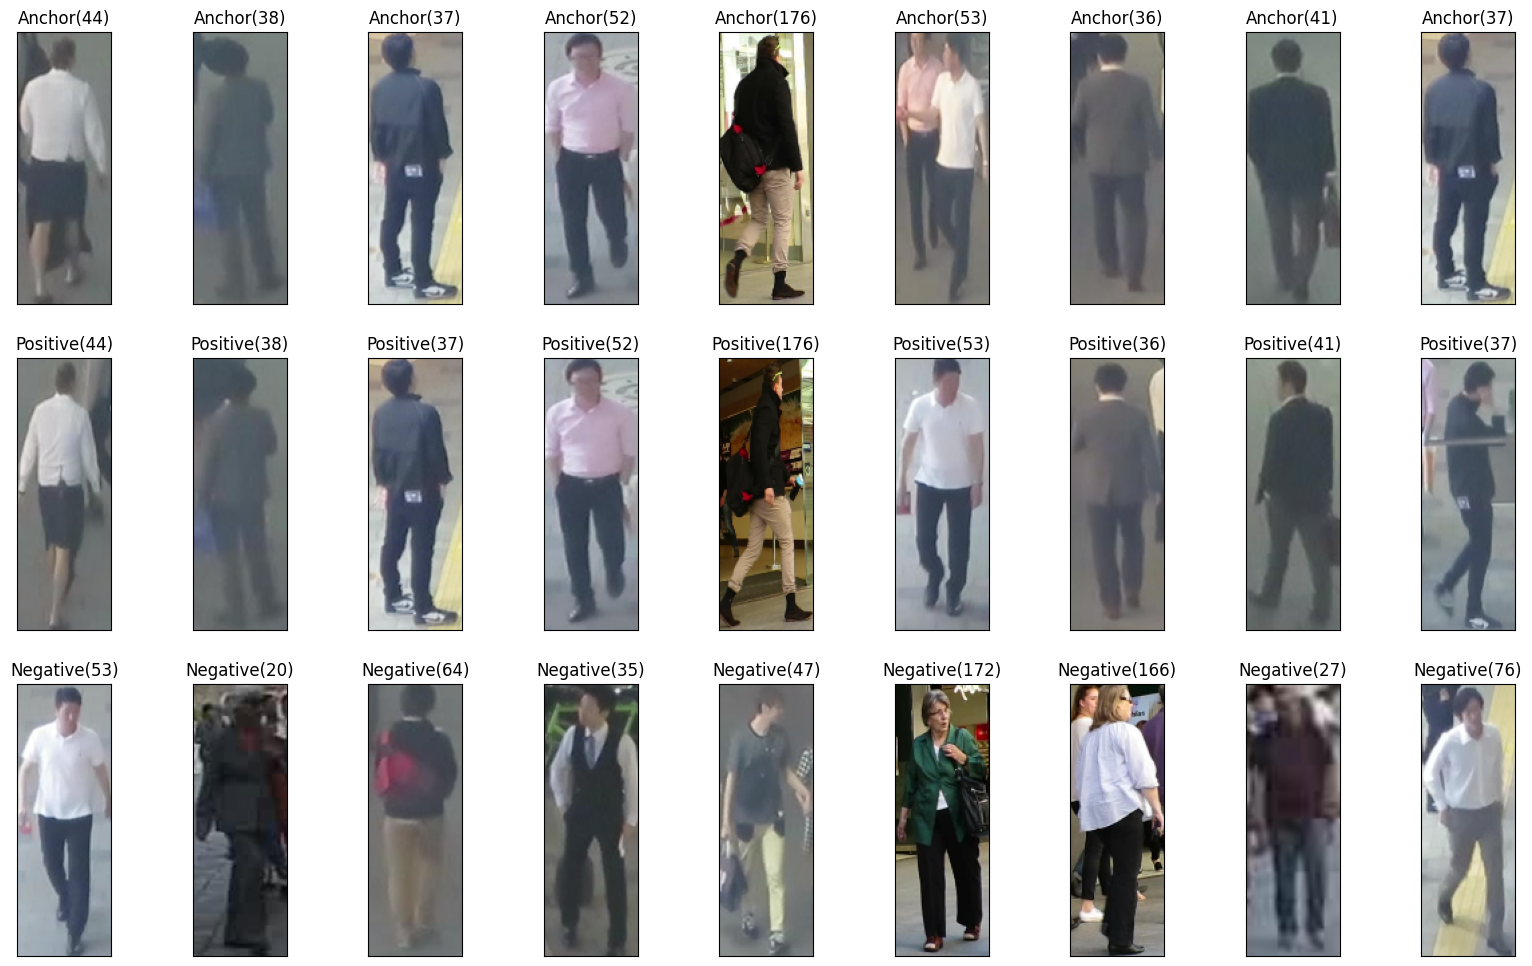

In [25]:
#def visualize(anchor, positive, negative):
#    """Visualize a few triplets from the supplied batches."""
#    def show(ax, image):
#        ax.imshow(image)
#        ax.get_xaxis().set_visible(False)
#        ax.get_yaxis().set_visible(False)
        #ax.set_title(f'Shape: {image.shape}')

#    fig = plt.figure(figsize=(9, 9))

#    axs = fig.subplots(3, 3)
#    for i in range(3):
#        show(axs[i, 0], anchor[i])
#        show(axs[i, 1], positive[i])
#        show(axs[i, 2], negative[i])

#visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

#def visualize(anchor, positive, negative):
#    """Visualize a few triplets from the supplied batches."""
#    def show(ax, image, title):
#        ax.imshow(image)
#        ax.get_xaxis().set_visible(False)
#        ax.get_yaxis().set_visible(False)
#        ax.set_title(title)

#    fig = plt.figure(figsize=(9, 9))

#    axs = fig.subplots(3, 3)
#    for i in range(3):
#        show(axs[i, 0], anchor[i], "Anchor")
#        show(axs[i, 1], positive[i], "Positive")
#        show(axs[i, 2], negative[i], "Negative")

#visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""
    def show(ax, image, title):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(title)
 
    fig, axs = plt.subplots(3, 9, figsize=(20, 12))
  
    for i in range(3):
        for j in range(9):
            if i == 0:
                show(axs[i, j], anchor[j], "Anchor("+ str(anchor_labels[j])+")")
            elif i == 1:
                show(axs[i, j], positive[j], "Positive("+ str(positive_labels[j])+")")
            else:
                show(axs[i, j], negative[j], "Negative("+ str(negative_labels[j])+")")

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

print(f'Train size: {len(anchor_images)}')
print(f'Train size: {len(anchor_labels)}')

for elemento in anchor_labels[:10] :
    print(elemento)

## Model implementation

### VGG-16

In [ ]:
base_cnn = vgg16.VGG16( weights="imagenet", input_shape=input_shape, include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
base_cnn.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 205, 71, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 205, 71, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 205, 71, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 102, 35, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 102, 35, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 102, 35, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 51, 17, 128)       0     

### Embedding network based on pretrained CNN

In [ ]:
# Creates an embedding network for image data using the VGG16 architecture as a 
# base convolutional neural network (CNN).

#     base_cnn = vgg16.VGG16( weights="imagenet", input_shape=input_shape, include_top=False): 
#      creates a VGG16 CNN with pre-trained weights from the ImageNet dataset and the specified 
#      input shape. The include_top=False argument means that the last fully connected layers of 
#      the original VGG16 architecture are excluded, allowing us to add our own layers later.

#     flatten = layers.Flatten()(base_cnn.output): takes the output of the VGG16 CNN and flattens 
#      it into a 1D vector, which is a common way to prepare features for input into a fully 
#      connected layer.

#     output = layers.Dense(256)(flatten): adds a fully connected layer with 256 neurons to the 
#      network, which will learn to generate the embedding vector for each input image.

#     embedding = keras.Model(base_cnn.input, output, name="Embedding"): constructs a new Keras 
#      Model that takes the input tensor of the VGG16 CNN and outputs the embedding vector 
#      produced by the fully connected layer. This new model is named "Embedding" for clarity.

#     return embedding: returns the newly created embedding network for use in training or evaluation

def create_embedding_network(input_shape):
    base_cnn = vgg16.VGG16( weights="imagenet", input_shape=input_shape, include_top=False)
    flatten = layers.Flatten()(base_cnn.output)
    output = layers.Dense(256)(flatten)
    embedding = keras.Model(base_cnn.input, output, name="Embedding")
    #trainable = False
    #for layer in base_cnn.layers:
    #    if layer.name == "block4_conv1":
    #        trainable = True
    #    layer.trainable = trainable
    return embedding

### Euclidean distance layer

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """  
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, anchor, positive, negative):
        dist_ap = tf.reduce_sum((anchor - positive)**2, -1)
        dist_an = tf.reduce_sum((anchor - negative)**2, -1)
        return dist_ap, dist_an 

### Siamese network

In [ ]:
# This function create_siamese_network(input_shape) creates a Siamese network model 
# for image recognition using the input_shape parameter to define the shape of the input 
# images. The function first creates an embedding network by calling create_embedding_network(input_shape) 
# function, which returns a Keras model that takes an image as input and outputs a dense embedding vector.

# Next, the function creates three input layers for the anchor, positive, and negative images. 
# Then, it passes these input layers through the embedding network to get the corresponding 
# embedding vectors. 

# The vgg16.preprocess_input() function is used to preprocess the images 
# before passing them to the embedding network.

# After that, the function uses a custom DistanceLayer() to compute the distances between the anchor 
# and positive embedding vectors, as well as between the anchor and negative embedding vectors.

# Finally, the function creates a Keras model with the three input layers and the output of the 
# DistanceLayer() as the output, and returns both the Siamese network and the embedding network 
# as a tuple. The Siamese network takes three images as input (anchor, positive, and negative), 
# and outputs a distance value that indicates how similar the anchor and positive images are 
# compared to the negative image.
    
def create_siamese_network(input_shape):
    # embedding network (vgg-16)
    embedding = create_embedding_network(input_shape)

    # input of the network
    anchor_input = keras.Input(shape=input_shape)
    positive_input = keras.Input(shape=input_shape)
    negative_input = keras.Input(shape=input_shape)

    # embeddings
    anchor_embedding = embedding(vgg16.preprocess_input(anchor_input))
    positive_embedding = embedding(vgg16.preprocess_input(positive_input))
    negative_embedding = embedding(vgg16.preprocess_input(negative_input))

    # distances (anchor-positive), (anchor-negative)
    distances = DistanceLayer()(anchor_embedding, positive_embedding,negative_embedding)

    # siamese module: input -> (anchor, positive, negative). output -> distances
    siamese_network = keras.Model([anchor_input, positive_input, negative_input], outputs=distances)
    return siamese_network, embedding

In [ ]:
siamese_network, embedding = create_siamese_network(input_shape)

In [ ]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 205, 71, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 205, 71, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_5 (InputLayer)           [(None, 205, 71, 3)  0           []                               
                                ]                                                             

### Siamese keras model

In [ ]:
# This code defines a custom Keras model class SiameseModel that inherits from the keras.
# Model base class. The SiameseModel class takes a siamese_network and a margin value as input. 
# The siamese_network is another Keras model that outputs an embedding vector for a given input 
# image, and the margin value is a scalar value used to calculate the loss.

# The call() method of the SiameseModel class calls the siamese_network to compute the embedding 
# vectors for the input images.

# The train_step() and test_step() methods of the SiameseModel class are used during training and 
# evaluation, respectively. They compute the loss for a batch of input data and update the model 
# weights accordingly. The _compute_loss() method calculates the loss using the embedding vectors 
# and the margin value.

# The metrics property returns a list containing the loss_tracker metric. The loss_tracker is an 
# instance of the tf.keras.metrics. Mean class that is used to compute and track the average loss 
# over multiple batches. The reset_states() method of the loss_tracker can be used to reset the 
# metric state.

class SiameseModel(keras.Model):
    """
    The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5): # call teh super class and assign our parameters
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data): # train based on batches
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(# parameters update
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker] #reset_states()

## Model training

In [ ]:
learning_rate = 5e-5
# learning_rate = 5e-6
num_epochs=5
# num_epochs=8
siamese_model = SiameseModel(siamese_network, margin=0.5)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate), weighted_metrics=[])
train_info = siamese_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/5
2289/2289 [==============================] - 890s 381ms/step - loss: 0.0325 - val_loss: 0.0118
Epoch 2/5
2289/2289 [==============================] - 857s 374ms/step - loss: 0.0266 - val_loss: 0.0435
Epoch 3/5
2289/2289 [==============================] - 856s 374ms/step - loss: 0.0264 - val_loss: 0.0331
Epoch 4/5
2289/2289 [==============================] - 854s 373ms/step - loss: 0.0286 - val_loss: 0.0070
Epoch 5/5
2289/2289 [==============================] - 853s 372ms/step - loss: 0.0235 - val_loss: 0.0022


### Loss per epoch


In [ ]:
def visualize_loss_curve(train_info):
    plt.plot(train_info.history["loss"], label="train_loss")
    plt.plot(train_info.history["val_loss"], label="val_loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

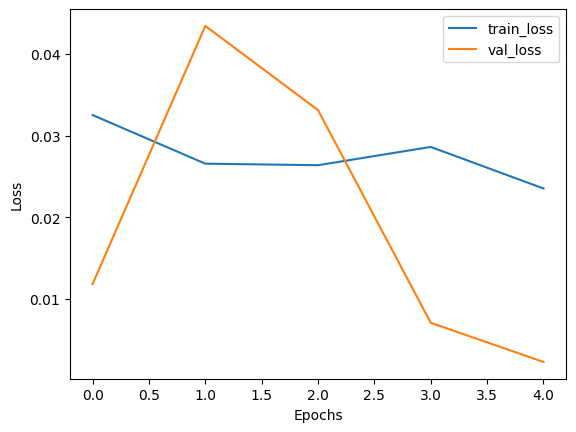

In [ ]:
visualize_loss_curve(train_info)

### Predictions

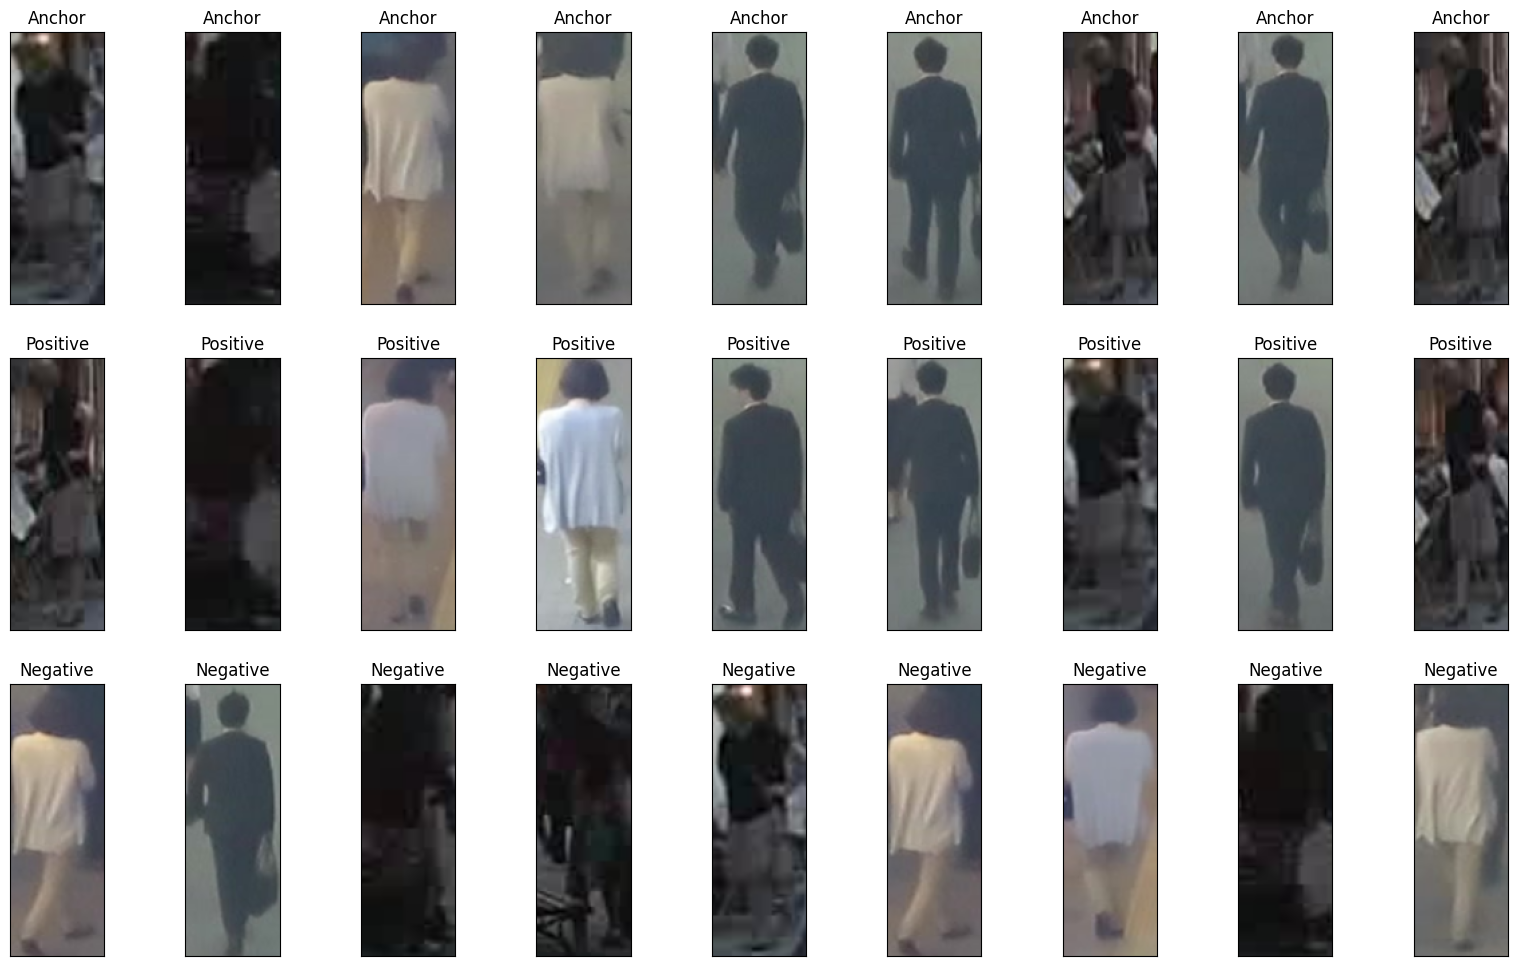

In [ ]:
sample = next(iter(val_dataset)) # take 1 random batch
visualize(*sample)

anchor, positive, negative = sample

In [ ]:
dist_ap, dist_an = siamese_model(sample)

In [ ]:
print("Anchor-Positive distance:", dist_ap.numpy().mean())
print("Anchor-Negative distance:", dist_an.numpy().mean())

Anchor-Positive distance: 2.1206965
Anchor-Negative distance: 35.93406


Validation size: 7069
Anchor-Positive Total Distance: 1.7617311
Anchor-Negative Total Distance: 31.626495
Total Distance Anchor-Positive: 221
Total Distance Anchor-Negative: 221
Total AP: 7069
Total AN: 7069


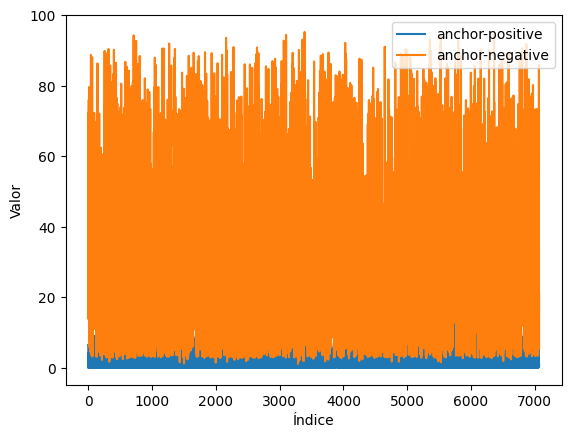

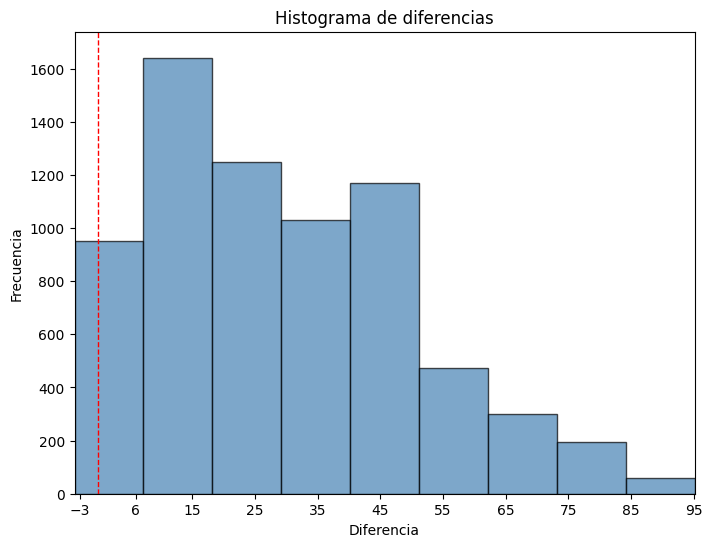

In [ ]:
contador = 0
num_total_img = 0
sum_dist_ap = []
sum_dist_an = []
all_dist_ap = []
all_dist_an = []
ap = []
an = []
for elemento in val_dataset:
    anchor, positive, negative = elemento
    dist_ap, dist_an = siamese_model(elemento)
    sum_dist_ap.append(dist_ap.numpy().mean())
    sum_dist_an.append(dist_an.numpy().mean())
    num_total_img = num_total_img + (len(anchor))
    all_dist_ap.append(dist_ap)
    all_dist_an.append(dist_an)

print("Validation size:", num_total_img)
print("Anchor-Positive Total Distance:", np.mean(sum_dist_ap))
print("Anchor-Negative Total Distance:", np.mean(sum_dist_an))
print("Total Distance Anchor-Positive:", len(all_dist_ap))
print("Total Distance Anchor-Negative:", len(all_dist_an))

for element in all_dist_ap:
  for d in element:
    ap.append(d)

print("Total AP:", len(ap))

for element in all_dist_an:
  for d in element:
    an.append(d)

print("Total AN:", len(an))

# Crear la figura y los ejes de la gráfica
fig, ax = plt.subplots()

# Graficar los dos vectores
ax.plot(ap, label='anchor-positive')
ax.plot(an, label='anchor-negative')

# Añadir leyenda y etiquetas de los ejes
ax.legend()
ax.set_xlabel('Índice')
ax.set_ylabel('Valor')

# Mostrar la gráfica
plt.show()

diferencias = np.subtract(an, ap)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Configurar el histograma
n_bins = 10  # Número de bins
range_min = min(diferencias)  # Valor mínimo
range_max = max(diferencias)  # Valor máximo
bins = np.linspace(range_min, range_max, n_bins)  # Rangos de los bins

# Crear el histograma
n, bins, patches = ax.hist(diferencias, bins=bins, color='steelblue', alpha=0.7, edgecolor='black')

# Personalizar los ejes y etiquetas
ax.set_xlabel('Diferencia')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de diferencias')

# Añadir una línea vertical en cero
ax.axvline(0, color='red', linestyle='dashed', linewidth=1)

# Ajustar los límites de los ejes
ax.set_xlim([range_min, range_max])
ax.set_ylim([0, max(n) + 100])

# Añadir más numeraciones en los ejes
ax.set_xticks(np.arange(range_min, range_max+1, (range_max-range_min)/10).astype(int))
#ax.set_yticks(np.arange(0, max(n)+100, 1).astype(int))

# Mostrar la gráfica
plt.show()

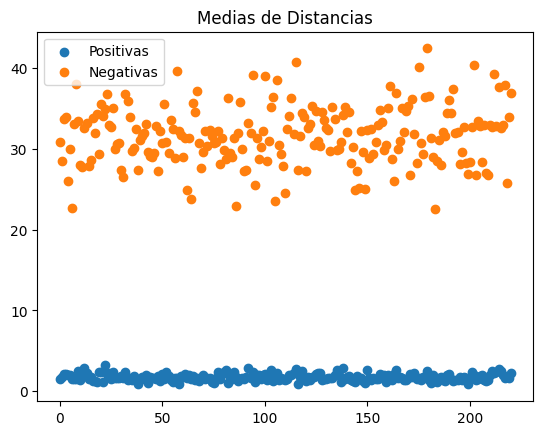

In [ ]:
x = np.arange(len(sum_dist_ap))

plt.scatter(x, sum_dist_ap, label='Positivas')
plt.scatter(x, sum_dist_an, label='Negativas')

plt.title('Medias de Distancias')
plt.legend()

plt.show()

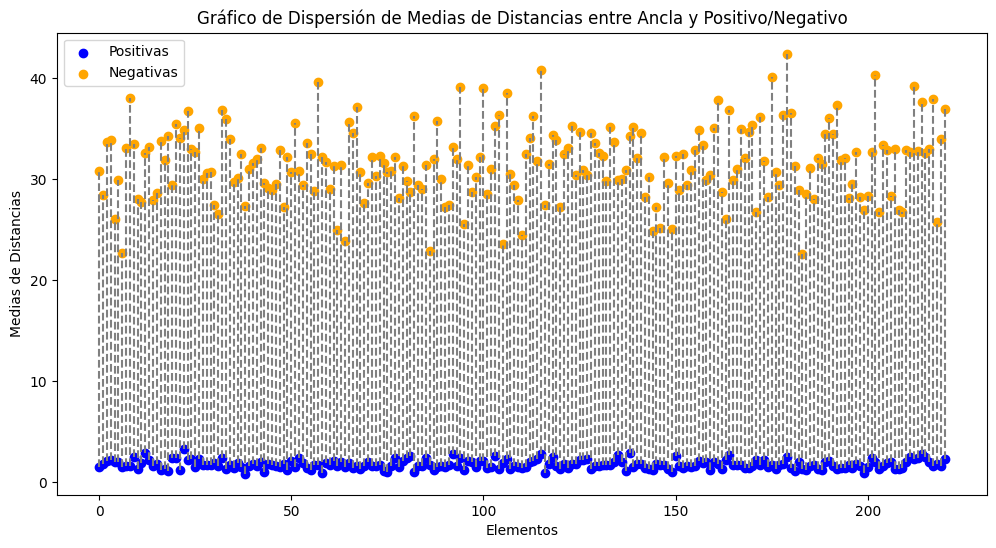

In [ ]:
# Índices para el eje x
indices = np.arange(len(sum_dist_ap))

# Crear el gráfico de dispersión con tamaño aumentado
plt.figure(figsize=(12, 6))
plt.scatter(indices, sum_dist_ap, label='Positivas', color='blue')
plt.scatter(indices, sum_dist_an, label='Negativas', color='orange')

# Trazar una línea entre las categorías
for i in range(len(indices)):
    plt.plot([indices[i], indices[i]], [sum_dist_ap[i], sum_dist_an[i]], '--', color='gray')

# Etiquetas de los ejes
plt.xlabel('Elementos')
plt.ylabel('Medias de Distancias')

# Título del gráfico
plt.title('Gráfico de Dispersión de Medias de Distancias entre Ancla y Positivo/Negativo')

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

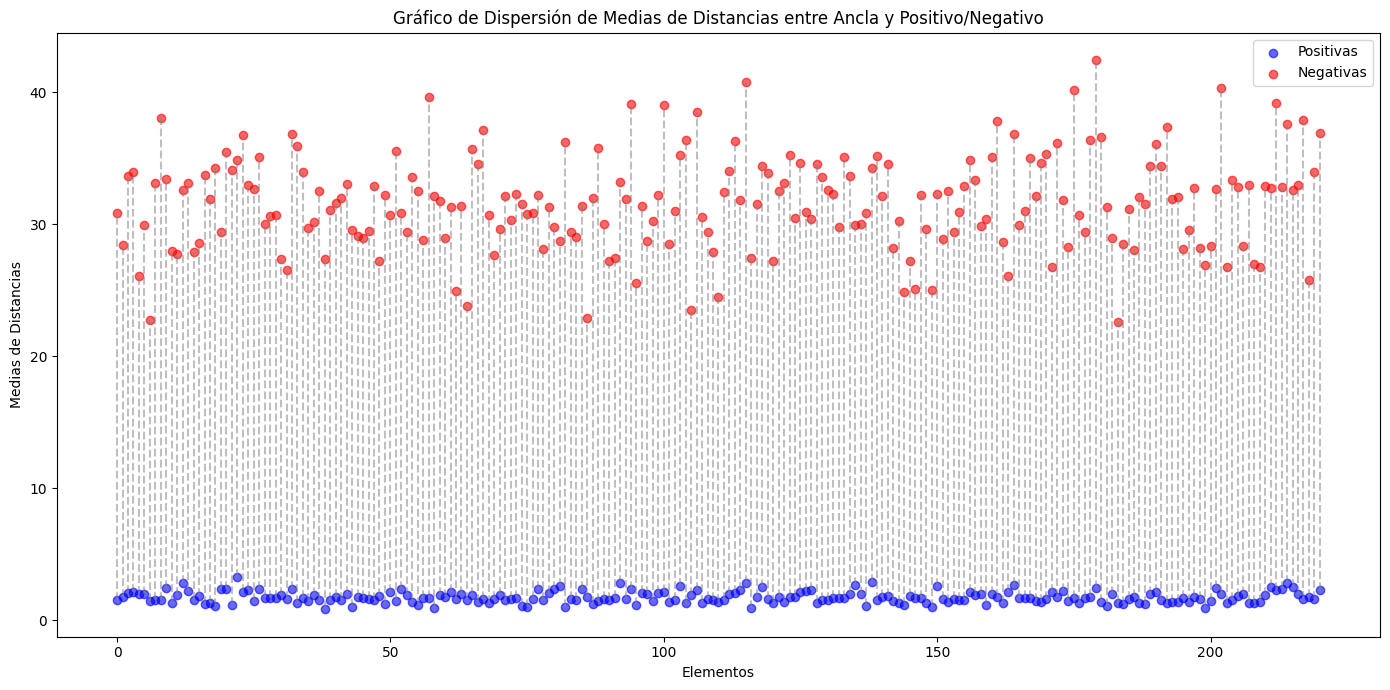

In [ ]:
# Índices para el eje x
indices = np.arange(len(sum_dist_ap))

# Crear el gráfico de dispersión con tamaño aumentado y transparencia en los puntos
plt.figure(figsize=(14, 7))
plt.scatter(indices, sum_dist_ap, label='Positivas', color='blue', alpha=0.6)
plt.scatter(indices, sum_dist_an, label='Negativas', color='red', alpha=0.6)

# Trazar líneas entre las categorías con mayor separación
for i in range(len(indices)):
    plt.plot([indices[i], indices[i]], [sum_dist_ap[i], sum_dist_an[i]], '--', color='gray', alpha=0.5)

# Etiquetas de los ejes
plt.xlabel('Elementos')
plt.ylabel('Medias de Distancias')

# Título del gráfico
plt.title('Gráfico de Dispersión de Medias de Distancias entre Ancla y Positivo/Negativo')

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

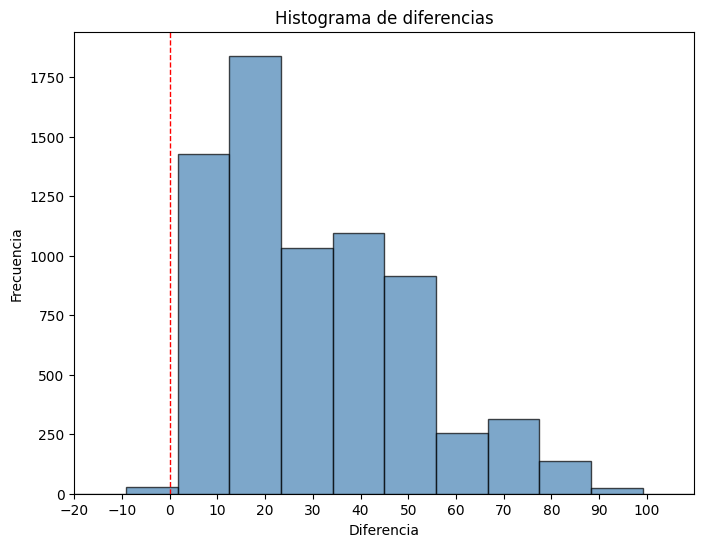

In [ ]:
diferencias = np.subtract(an, ap)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Configurar el histograma
n_bins = 13  # Número de bins
range_min = -20  # Valor mínimo
range_max = 110  # Valor máximo
bins = np.linspace(range_min, range_max, n_bins)  # Rangos de los bins

# Crear el histograma
n, bins, patches = ax.hist(diferencias, bins=bins, color='steelblue', alpha=0.7, edgecolor='black')

# Personalizar los ejes y etiquetas
ax.set_xlabel('Diferencia')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de diferencias')

# Añadir una línea vertical en cero
ax.axvline(0, color='red', linestyle='dashed', linewidth=1)

# Ajustar los límites de los ejes
ax.set_xlim([range_min, range_max])
ax.set_ylim([0, max(n) + 100])

# Añadir más numeraciones en los ejes
ax.set_xticks(np.arange(range_min, range_max, (range_max-range_min)/n_bins).astype(int))

# Mostrar la gráfica
plt.show()

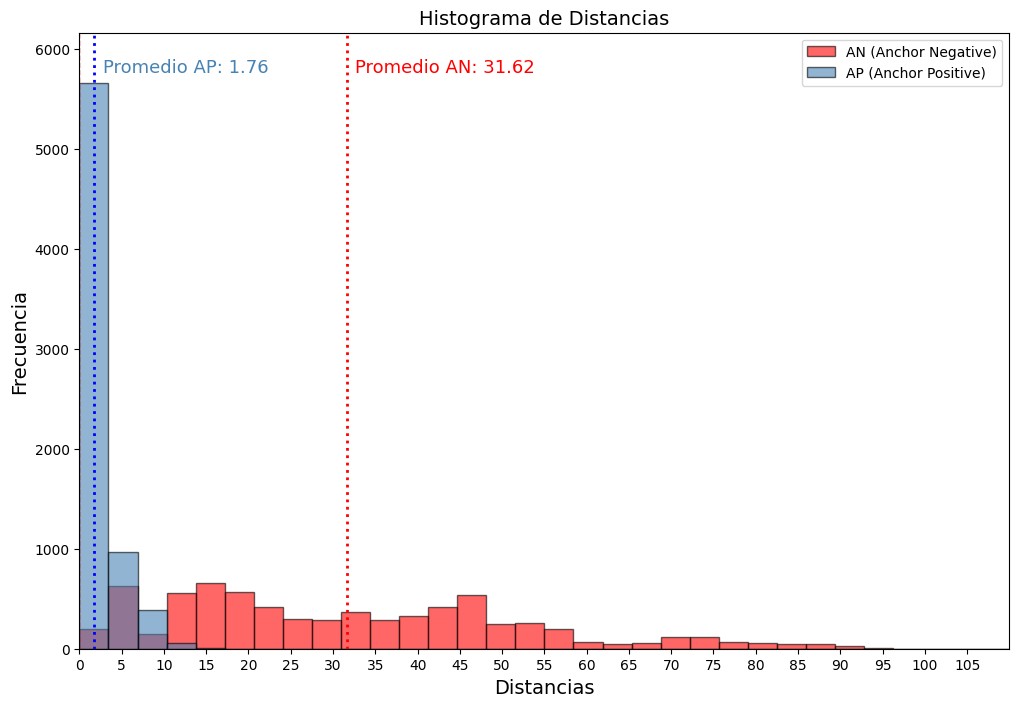

In [ ]:
# Datos de los vectores
diferencias_an = an
diferencias_ap = ap

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Configurar el histograma
n_bins = 33  # Número de bins
range_min = 0  # Valor mínimo
range_max = 110  # Valor máximo
bins = np.linspace(range_min, range_max, n_bins)  # Rangos de los bins

# Crear el histograma para diferencias_an
n_an, bins_an, patches_an = ax.hist(diferencias_an, bins=bins, color='red', alpha=0.6, edgecolor='black', label='AN (Anchor Negative)')

# Crear el histograma para diferencias_ap
n_ap, bins_ap, patches_ap = ax.hist(diferencias_ap, bins=bins, color='steelblue', alpha=0.6, edgecolor='black', label='AP (Anchor Positive)')

# Personalizar los ejes y etiquetas
ax.set_xlabel('Distancias', fontsize =14)
ax.set_ylabel('Frecuencia', fontsize =14)
ax.set_title('Histograma de Distancias', fontsize =14)

# Añadir una línea vertical en cero
ax.axvline(0, color='red', linestyle='dashed', linewidth=1)

# Ajustar los límites de los ejes
ax.set_xlim([range_min, range_max])
ax.set_ylim([0, max(max(n_an), max(n_ap)) + 500])

# Añadir más numeraciones en los ejes
ax.set_xticks(np.arange(range_min, range_max, (range_max-range_min)/22).astype(int))
#ax.set_yticks(np.arange(0, max(max(n_an), max(n_ap))+100, 1).astype(int))

# Calcular y mostrar el promedio de diferencias_an
avg_an = np.mean(diferencias_an)
ax.axvline(avg_an, color='red', linestyle='dotted', linewidth=2)
ax.text(avg_an+1, max(max(n_an), max(n_ap)) +100, f'Promedio AN: {avg_an:.2f}', color='red', ha='left', fontsize =13)

# Calcular y mostrar el promedio de diferencias_ap
avg_ap = np.mean(diferencias_ap)
ax.axvline(avg_ap, color='blue', linestyle='dotted', linewidth=2)
ax.text(avg_ap+1, max(max(n_an), max(n_ap)) + 100, f'Promedio AP: {avg_ap:.2f}', color='steelblue', ha='left', fontsize =13)

# Añadir leyenda
ax.legend()

# Mostrar la gráfica
plt.show()